In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [25]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [26]:
y.shape

(144, 2)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(129, 113)

In [29]:
y_train.shape

(129, 2)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=16, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 16)                2064      
                                                                 
 outputLayer (Dense)         (None, 2)                 34    

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=200, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [35]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [36]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
6/6 [==============================] - 6s 7ms/step - loss: 0.5643 - rmse: 0.7512 - lr: 0.0010
Epoch 2/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.1581 - rmse: 0.3976 - lr: 0.0010
Epoch 3/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.1346 - rmse: 0.3668 - lr: 0.0010
Epoch 4/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0872 - rmse: 0.2953 - lr: 0.0010
Epoch 5/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0607 - rmse: 0.2463 - lr: 0.0010
Epoch 6/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0483 - rmse: 0.2197 - lr: 0.0010
Epoch 7/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0355 - rmse: 0.1884 - lr: 0.0010
Epoch 8/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0230 - rmse: 0.1517 - lr: 0.0010
Epoch 9/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0213 - rmse: 0.1458 - lr: 0.0010
Epoch 10/5000
6/6 [==================

Epoch 77/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0028 - rmse: 0.0528 - lr: 0.0010
Epoch 78/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0025 - rmse: 0.0504 - lr: 0.0010
Epoch 79/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0381 - lr: 0.0010
Epoch 80/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0018 - rmse: 0.0422 - lr: 0.0010
Epoch 81/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.6447e-04 - rmse: 0.0311 - lr: 0.0010
Epoch 82/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0331 - lr: 0.0010
Epoch 83/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0014 - rmse: 0.0368 - lr: 0.0010
Epoch 84/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.9748e-04 - rmse: 0.0264 - lr: 0.0010
Epoch 85/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.7914e-04 - rmse: 0.0261 - lr: 0.0010
Epoch 86/5000
6/

6/6 [==============================] - 0s 6ms/step - loss: 8.9165e-05 - rmse: 0.0094 - lr: 0.0010
Epoch 151/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0139e-04 - rmse: 0.0101 - lr: 0.0010
Epoch 152/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.4015e-05 - rmse: 0.0086 - lr: 0.0010
Epoch 153/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.8230e-05 - rmse: 0.0083 - lr: 0.0010
Epoch 154/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.8894e-05 - rmse: 0.0089 - lr: 0.0010
Epoch 155/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.4098e-05 - rmse: 0.0080 - lr: 0.0010
Epoch 156/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.0047e-05 - rmse: 0.0071 - lr: 0.0010
Epoch 157/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.2469e-05 - rmse: 0.0079 - lr: 0.0010
Epoch 158/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.3030e-05 - rmse: 0.0079 - lr: 0.001

6/6 [==============================] - 0s 6ms/step - loss: 0.0027 - rmse: 0.0524 - lr: 0.0010
Epoch 223/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0037 - rmse: 0.0608 - lr: 0.0010
Epoch 224/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0045 - rmse: 0.0668 - lr: 0.0010
Epoch 225/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0030 - rmse: 0.0546 - lr: 0.0010
Epoch 226/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0412 - lr: 0.0010
Epoch 227/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0037 - rmse: 0.0605 - lr: 0.0010
Epoch 228/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0404 - lr: 0.0010
Epoch 229/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.5420e-04 - rmse: 0.0275 - lr: 0.0010
Epoch 230/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.7655e-04 - rmse: 0.0312 - lr: 0.0010
Epoch 231/5000
6/6 [======

Epoch 295/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.4676e-05 - rmse: 0.0059 - lr: 0.0010
Epoch 296/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.9536e-05 - rmse: 0.0070 - lr: 0.0010
Epoch 297/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.4320e-05 - rmse: 0.0092 - lr: 0.0010
Epoch 298/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.6412e-05 - rmse: 0.0093 - lr: 0.0010
Epoch 299/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.5381e-05 - rmse: 0.0067 - lr: 0.0010
Epoch 300/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.4090e-05 - rmse: 0.0058 - lr: 0.0010
Epoch 301/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.3187e-05 - rmse: 0.0058 - lr: 0.0010
Epoch 302/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.3412e-05 - rmse: 0.0048 - lr: 0.0010
Epoch 303/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0933e-05 - rmse: 0.0

6/6 [==============================] - 0s 6ms/step - loss: 1.2857e-04 - rmse: 0.0113 - lr: 0.0010
Epoch 368/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1247e-04 - rmse: 0.0106 - lr: 0.0010
Epoch 369/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2776e-04 - rmse: 0.0113 - lr: 0.0010
Epoch 370/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.3365e-05 - rmse: 0.0086 - lr: 0.0010
Epoch 371/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.9449e-05 - rmse: 0.0083 - lr: 0.0010
Epoch 372/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.7613e-05 - rmse: 0.0088 - lr: 0.0010
Epoch 373/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.2550e-05 - rmse: 0.0091 - lr: 0.0010
Epoch 374/5000
6/6 [==============================] - 0s 5ms/step - loss: 7.1206e-05 - rmse: 0.0084 - lr: 0.0010
Epoch 375/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.8443e-05 - rmse: 0.0094 - lr: 0.001

6/6 [==============================] - 0s 5ms/step - loss: 3.7084e-04 - rmse: 0.0193 - lr: 0.0010
Epoch 441/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8698e-04 - rmse: 0.0137 - lr: 0.0010
Epoch 442/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.1467e-04 - rmse: 0.0147 - lr: 0.0010
Epoch 443/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6909e-04 - rmse: 0.0130 - lr: 0.0010
Epoch 444/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.0116e-04 - rmse: 0.0142 - lr: 0.0010
Epoch 445/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.7229e-04 - rmse: 0.0165 - lr: 0.0010
Epoch 446/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4949e-04 - rmse: 0.0122 - lr: 0.0010
Epoch 447/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2121e-04 - rmse: 0.0110 - lr: 0.0010
Epoch 448/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.1016e-04 - rmse: 0.0105 - lr: 0.001

6/6 [==============================] - 0s 6ms/step - loss: 1.3631e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 513/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.0925e-05 - rmse: 0.0033 - lr: 0.0010
Epoch 514/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1762e-05 - rmse: 0.0034 - lr: 0.0010
Epoch 515/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4400e-05 - rmse: 0.0038 - lr: 0.0010
Epoch 516/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4556e-05 - rmse: 0.0038 - lr: 0.0010
Epoch 517/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5065e-05 - rmse: 0.0039 - lr: 0.0010
Epoch 518/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5104e-05 - rmse: 0.0039 - lr: 0.0010
Epoch 519/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1905e-05 - rmse: 0.0035 - lr: 0.0010
Epoch 520/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4195e-05 - rmse: 0.0038 - lr: 0.001

Epoch 582/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.9381e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 583/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.0050e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 584/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.1384e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 585/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.6408e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 586/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.2977e-06 - rmse: 0.0021 - lr: 5.0000e-04
Epoch 587/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.8864e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 588/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.7699e-06 - rmse: 0.0022 - lr: 5.0000e-04
Epoch 589/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.4701e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 590/5000
6/6 [==============================] - 0s 7ms/ste

6/6 [==============================] - 0s 7ms/step - loss: 3.8902e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 653/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.0184e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 654/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.8052e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 655/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.0244e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 656/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.5537e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 657/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.4018e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 658/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.1012e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 659/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.1923e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 660/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.687

6/6 [==============================] - 0s 5ms/step - loss: 8.4005e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 723/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.1401e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 724/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.8758e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 725/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.1919e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 726/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.0519e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 727/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.3873e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 728/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.5106e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 729/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2635e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 730/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.613

6/6 [==============================] - 0s 5ms/step - loss: 8.4389e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 793/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.1099e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 794/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.1752e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 795/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.2615e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 796/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.0676e-06 - rmse: 0.0018 - lr: 5.0000e-04
Epoch 797/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.5100e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 798/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.5779e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 799/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.5621e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 800/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.777

6/6 [==============================] - 0s 6ms/step - loss: 1.7508e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 863/5000
6/6 [==============================] - 0s 5ms/step - loss: 9.7866e-06 - rmse: 0.0031 - lr: 5.0000e-04
Epoch 864/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2071e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 865/5000
6/6 [==============================] - 0s 6ms/step - loss: 9.8659e-06 - rmse: 0.0031 - lr: 5.0000e-04
Epoch 866/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6268e-05 - rmse: 0.0040 - lr: 5.0000e-04
Epoch 867/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2626e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 868/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3737e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 869/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.8677e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 870/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.096

6/6 [==============================] - 0s 5ms/step - loss: 5.3423e-05 - rmse: 0.0073 - lr: 5.0000e-04
Epoch 933/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.7010e-05 - rmse: 0.0076 - lr: 5.0000e-04
Epoch 934/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.4982e-05 - rmse: 0.0074 - lr: 5.0000e-04
Epoch 935/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.6363e-05 - rmse: 0.0075 - lr: 5.0000e-04
Epoch 936/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.2554e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 937/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.1920e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 938/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3823e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 939/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2757e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 940/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.148

6/6 [==============================] - 0s 6ms/step - loss: 8.5152e-04 - rmse: 0.0292 - lr: 5.0000e-04
Epoch 1003/5000
6/6 [==============================] - 0s 5ms/step - loss: 7.6736e-04 - rmse: 0.0277 - lr: 5.0000e-04
Epoch 1004/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0336 - lr: 5.0000e-04
Epoch 1005/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.7615e-04 - rmse: 0.0279 - lr: 5.0000e-04
Epoch 1006/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.8005e-04 - rmse: 0.0261 - lr: 5.0000e-04
Epoch 1007/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.7891e-04 - rmse: 0.0241 - lr: 5.0000e-04
Epoch 1008/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.5440e-04 - rmse: 0.0235 - lr: 5.0000e-04
Epoch 1009/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.2470e-04 - rmse: 0.0180 - lr: 5.0000e-04
Epoch 1010/5000
6/6 [==============================] - 0s 5ms/step - loss: 1

6/6 [==============================] - 0s 6ms/step - loss: 7.4003e-06 - rmse: 0.0027 - lr: 2.5000e-04
Epoch 1071/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.7103e-06 - rmse: 0.0026 - lr: 2.5000e-04
Epoch 1072/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.8562e-06 - rmse: 0.0024 - lr: 2.5000e-04
Epoch 1073/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.6620e-06 - rmse: 0.0024 - lr: 2.5000e-04
Epoch 1074/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.9908e-06 - rmse: 0.0022 - lr: 2.5000e-04
Epoch 1075/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.3729e-06 - rmse: 0.0025 - lr: 2.5000e-04
Epoch 1076/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.0476e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1077/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.9155e-06 - rmse: 0.0026 - lr: 2.5000e-04
Epoch 1078/5000
6/6 [==============================] - 0s 6ms/step - los

6/6 [==============================] - 0s 5ms/step - loss: 4.5221e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1140/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.7628e-06 - rmse: 0.0019 - lr: 2.5000e-04
Epoch 1141/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.6660e-06 - rmse: 0.0019 - lr: 2.5000e-04
Epoch 1142/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.6760e-06 - rmse: 0.0019 - lr: 2.5000e-04
Epoch 1143/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.1292e-06 - rmse: 0.0018 - lr: 2.5000e-04
Epoch 1144/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.4215e-06 - rmse: 0.0018 - lr: 2.5000e-04
Epoch 1145/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.7991e-06 - rmse: 0.0022 - lr: 2.5000e-04
Epoch 1146/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.2721e-06 - rmse: 0.0018 - lr: 2.5000e-04
Epoch 1147/5000
6/6 [==============================] - 0s 5ms/step - los

6/6 [==============================] - 0s 5ms/step - loss: 4.2310e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1209/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.8690e-06 - rmse: 0.0020 - lr: 2.5000e-04
Epoch 1210/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.5334e-06 - rmse: 0.0024 - lr: 2.5000e-04
Epoch 1211/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.5272e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1212/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.4989e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1213/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.0931e-06 - rmse: 0.0020 - lr: 2.5000e-04
Epoch 1214/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.6038e-06 - rmse: 0.0019 - lr: 2.5000e-04
Epoch 1215/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.5344e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1216/5000
6/6 [==============================] - 0s 5ms/step - los

6/6 [==============================] - 0s 5ms/step - loss: 1.9935e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1278/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5528e-06 - rmse: 0.0012 - lr: 2.5000e-04
Epoch 1279/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.8697e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1280/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0384e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1281/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6937e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1282/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.2321e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1283/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.9925e-06 - rmse: 0.0022 - lr: 2.5000e-04
Epoch 1284/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.8815e-06 - rmse: 0.0017 - lr: 2.5000e-04
Epoch 1285/5000
6/6 [==============================] - 0s 5ms/step - los

6/6 [==============================] - 0s 5ms/step - loss: 3.4000e-06 - rmse: 0.0018 - lr: 2.5000e-04
Epoch 1347/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.6110e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1348/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.5536e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1349/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.8459e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1350/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8124e-06 - rmse: 0.0013 - lr: 2.5000e-04
Epoch 1351/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4992e-06 - rmse: 0.0012 - lr: 2.5000e-04
Epoch 1352/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.9099e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1353/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.7097e-06 - rmse: 0.0013 - lr: 2.5000e-04
Epoch 1354/5000
6/6 [==============================] - 0s 5ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 8.4401e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 1416/5000
6/6 [==============================] - 0s 5ms/step - loss: 9.9582e-06 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1417/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.8967e-06 - rmse: 0.0030 - lr: 2.5000e-04
Epoch 1418/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.8448e-06 - rmse: 0.0024 - lr: 2.5000e-04
Epoch 1419/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.6207e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1420/5000
6/6 [==============================] - 0s 6ms/step - loss: 7.7892e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1421/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.1243e-06 - rmse: 0.0025 - lr: 2.5000e-04
Epoch 1422/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.0117e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1423/5000
6/6 [==============================] - 0s 5ms/step - los

6/6 [==============================] - 0s 5ms/step - loss: 5.0094e-06 - rmse: 0.0022 - lr: 2.5000e-04
Epoch 1485/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.9715e-06 - rmse: 0.0026 - lr: 2.5000e-04
Epoch 1486/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.2885e-06 - rmse: 0.0023 - lr: 2.5000e-04
Epoch 1487/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.2453e-06 - rmse: 0.0021 - lr: 2.5000e-04
Epoch 1488/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.9366e-06 - rmse: 0.0017 - lr: 2.5000e-04
Epoch 1489/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.7188e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1490/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.1633e-06 - rmse: 0.0023 - lr: 2.5000e-04
Epoch 1491/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.2880e-06 - rmse: 0.0025 - lr: 2.5000e-04
Epoch 1492/5000
6/6 [==============================] - 0s 5ms/step - los

6/6 [==============================] - 0s 5ms/step - loss: 6.0473e-06 - rmse: 0.0025 - lr: 2.5000e-04
Epoch 1554/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.7436e-06 - rmse: 0.0022 - lr: 2.5000e-04
Epoch 1555/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3572e-05 - rmse: 0.0037 - lr: 2.5000e-04
Epoch 1556/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.9631e-06 - rmse: 0.0022 - lr: 2.5000e-04
Epoch 1557/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.2707e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 1558/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.1155e-06 - rmse: 0.0028 - lr: 2.5000e-04
Epoch 1559/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.0069e-05 - rmse: 0.0032 - lr: 2.5000e-04
Epoch 1560/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.5145e-06 - rmse: 0.0029 - lr: 2.5000e-04
Epoch 1561/5000
1/6 [====>.........................] - ETA: 0s - loss: 3

6/6 [==============================] - 0s 5ms/step - loss: 5.7563e-07 - rmse: 7.5870e-04 - lr: 1.2500e-04
Epoch 1620/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.3275e-07 - rmse: 6.5784e-04 - lr: 1.2500e-04
Epoch 1621/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.4034e-07 - rmse: 7.3508e-04 - lr: 1.2500e-04
Epoch 1622/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.1815e-07 - rmse: 7.1983e-04 - lr: 1.2500e-04
Epoch 1623/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.3775e-07 - rmse: 7.9859e-04 - lr: 1.2500e-04
Epoch 1624/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.8867e-07 - rmse: 8.2986e-04 - lr: 1.2500e-04
Epoch 1625/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.5102e-07 - rmse: 8.0686e-04 - lr: 1.2500e-04
Epoch 1626/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.7536e-07 - rmse: 8.2180e-04 - lr: 1.2500e-04
Epoch 1627/5000
6/6 [===================

Epoch 1687/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.7647e-07 - rmse: 8.2248e-04 - lr: 1.2500e-04
Epoch 1688/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0779e-06 - rmse: 0.0010 - lr: 1.2500e-04
Epoch 1689/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.4878e-07 - rmse: 9.2129e-04 - lr: 1.2500e-04
Epoch 1690/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3352e-06 - rmse: 0.0012 - lr: 1.2500e-04
Epoch 1691/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2025e-06 - rmse: 0.0011 - lr: 1.2500e-04
Epoch 1692/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.5054e-07 - rmse: 8.0656e-04 - lr: 1.2500e-04
Epoch 1693/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0621e-06 - rmse: 0.0010 - lr: 1.2500e-04
Epoch 1694/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.0601e-07 - rmse: 8.9778e-04 - lr: 1.2500e-04
Epoch 1695/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 1.1053e-06 - rmse: 0.0011 - lr: 1.2500e-04
Epoch 1756/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9264e-06 - rmse: 0.0014 - lr: 1.2500e-04
Epoch 1757/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.7094e-06 - rmse: 0.0013 - lr: 1.2500e-04
Epoch 1758/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.6832e-06 - rmse: 0.0016 - lr: 1.2500e-04
Epoch 1759/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.1523e-06 - rmse: 0.0015 - lr: 1.2500e-04
Epoch 1760/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6758e-06 - rmse: 0.0013 - lr: 1.2500e-04
Epoch 1761/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6544e-06 - rmse: 0.0013 - lr: 1.2500e-04
Epoch 1762/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2917e-06 - rmse: 0.0011 - lr: 1.2500e-04
Epoch 1763/5000
6/6 [==============================] - 0s 6ms/step - los

Epoch 1824/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.0449e-06 - rmse: 0.0017 - lr: 1.2500e-04
Epoch 1825/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.9140e-06 - rmse: 0.0017 - lr: 1.2500e-04
Epoch 1826/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5550e-06 - rmse: 0.0019 - lr: 1.2500e-04
Epoch 1827/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.0176e-06 - rmse: 0.0010 - lr: 1.2500e-04
Epoch 1828/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.4131e-06 - rmse: 0.0012 - lr: 1.2500e-04
Epoch 1829/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2565e-06 - rmse: 0.0011 - lr: 1.2500e-04
Epoch 1830/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.5089e-07 - rmse: 9.2244e-04 - lr: 1.2500e-04
Epoch 1831/5000
6/6 [==============================] - 0s 6ms/step - loss: 8.3938e-07 - rmse: 9.1618e-04 - lr: 1.2500e-04
Epoch 1832/5000
6/6 [===========================

6/6 [==============================] - 0s 6ms/step - loss: 6.2828e-07 - rmse: 7.9264e-04 - lr: 6.2500e-05
Epoch 1891/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.0184e-07 - rmse: 7.7578e-04 - lr: 6.2500e-05
Epoch 1892/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.6786e-07 - rmse: 8.1723e-04 - lr: 6.2500e-05
Epoch 1893/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.2107e-07 - rmse: 6.4890e-04 - lr: 6.2500e-05
Epoch 1894/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.1205e-07 - rmse: 5.5862e-04 - lr: 6.2500e-05
Epoch 1895/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5919e-07 - rmse: 5.9933e-04 - lr: 6.2500e-05
Epoch 1896/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.8635e-07 - rmse: 5.3512e-04 - lr: 6.2500e-05
Epoch 1897/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.3186e-07 - rmse: 5.7607e-04 - lr: 6.2500e-05
Epoch 1898/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 2.6743e-07 - rmse: 5.1714e-04 - lr: 6.2500e-05
Epoch 1958/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.4479e-07 - rmse: 8.0299e-04 - lr: 6.2500e-05
Epoch 1959/5000
6/6 [==============================] - 0s 6ms/step - loss: 5.0501e-07 - rmse: 7.1064e-04 - lr: 6.2500e-05
Epoch 1960/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.3250e-07 - rmse: 6.5765e-04 - lr: 6.2500e-05
Epoch 1961/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.4266e-07 - rmse: 6.6532e-04 - lr: 6.2500e-05
Epoch 1962/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.5963e-07 - rmse: 5.9970e-04 - lr: 6.2500e-05
Epoch 1963/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.8751e-07 - rmse: 5.3620e-04 - lr: 6.2500e-05
Epoch 1964/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.1543e-07 - rmse: 6.4454e-04 - lr: 6.2500e-05
Epoch 1965/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 5.6689e-07 - rmse: 7.5292e-04 - lr: 6.2500e-05
Epoch 2025/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.5205e-07 - rmse: 7.4300e-04 - lr: 6.2500e-05
Epoch 2026/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.5618e-07 - rmse: 8.1005e-04 - lr: 6.2500e-05
Epoch 2027/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.7731e-07 - rmse: 8.2299e-04 - lr: 6.2500e-05
Epoch 2028/5000
6/6 [==============================] - 0s 5ms/step - loss: 9.1476e-07 - rmse: 9.5643e-04 - lr: 6.2500e-05
Epoch 2029/5000
6/6 [==============================] - 0s 5ms/step - loss: 8.8709e-07 - rmse: 9.4185e-04 - lr: 6.2500e-05
Epoch 2030/5000
6/6 [==============================] - 0s 6ms/step - loss: 6.5851e-07 - rmse: 8.1149e-04 - lr: 6.2500e-05
Epoch 2031/5000
6/6 [==============================] - 0s 5ms/step - loss: 7.2329e-07 - rmse: 8.5047e-04 - lr: 6.2500e-05
Epoch 2032/5000
6/6 [===================

6/6 [==============================] - 0s 6ms/step - loss: 2.1188e-07 - rmse: 4.6031e-04 - lr: 3.1250e-05
Epoch 2091/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.6536e-07 - rmse: 5.1513e-04 - lr: 3.1250e-05
Epoch 2092/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.2860e-07 - rmse: 4.7812e-04 - lr: 3.1250e-05
Epoch 2093/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6364e-07 - rmse: 5.1346e-04 - lr: 3.1250e-05
Epoch 2094/5000
6/6 [==============================] - 0s 5ms/step - loss: 3.5490e-07 - rmse: 5.9573e-04 - lr: 3.1250e-05
Epoch 2095/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.7882e-07 - rmse: 5.2803e-04 - lr: 3.1250e-05
Epoch 2096/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.0070e-07 - rmse: 4.4799e-04 - lr: 3.1250e-05
Epoch 2097/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.5451e-07 - rmse: 5.0449e-04 - lr: 3.1250e-05
Epoch 2098/5000
6/6 [===================

6/6 [==============================] - 0s 6ms/step - loss: 1.9760e-07 - rmse: 4.4453e-04 - lr: 3.1250e-05
Epoch 2158/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9418e-07 - rmse: 4.4066e-04 - lr: 3.1250e-05
Epoch 2159/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0948e-07 - rmse: 4.5769e-04 - lr: 3.1250e-05
Epoch 2160/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0956e-07 - rmse: 4.5778e-04 - lr: 3.1250e-05
Epoch 2161/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6855e-07 - rmse: 5.1822e-04 - lr: 3.1250e-05
Epoch 2162/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.4803e-07 - rmse: 4.9803e-04 - lr: 3.1250e-05
Epoch 2163/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.5281e-07 - rmse: 5.0280e-04 - lr: 3.1250e-05
Epoch 2164/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.2500e-07 - rmse: 4.7435e-04 - lr: 3.1250e-05
Epoch 2165/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 2.2197e-07 - rmse: 4.7114e-04 - lr: 3.1250e-05
Epoch 2225/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.0600e-07 - rmse: 4.5387e-04 - lr: 3.1250e-05
Epoch 2226/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.9596e-07 - rmse: 4.4267e-04 - lr: 3.1250e-05
Epoch 2227/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7698e-07 - rmse: 4.2068e-04 - lr: 3.1250e-05
Epoch 2228/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.9178e-07 - rmse: 5.4017e-04 - lr: 3.1250e-05
Epoch 2229/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.3993e-07 - rmse: 6.6327e-04 - lr: 3.1250e-05
Epoch 2230/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.1417e-07 - rmse: 6.4356e-04 - lr: 3.1250e-05
Epoch 2231/5000
6/6 [==============================] - 0s 6ms/step - loss: 4.1704e-07 - rmse: 6.4579e-04 - lr: 3.1250e-05
Epoch 2232/5000
6/6 [===================

Epoch 2290/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.5417e-07 - rmse: 5.0415e-04 - lr: 1.5625e-05
Epoch 2291/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.0228e-07 - rmse: 5.4980e-04 - lr: 1.5625e-05
Epoch 2292/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6221e-07 - rmse: 5.1207e-04 - lr: 1.5625e-05
Epoch 2293/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.2592e-07 - rmse: 5.7090e-04 - lr: 1.5625e-05
Epoch 2294/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.6584e-07 - rmse: 5.1560e-04 - lr: 1.5625e-05
Epoch 2295/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.0739e-07 - rmse: 4.5540e-04 - lr: 1.5625e-05
Epoch 2296/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.2067e-07 - rmse: 4.6976e-04 - lr: 1.5625e-05
Epoch 2297/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6943e-07 - rmse: 4.1161e-04 - lr: 1.5625e-05
Epoch 2298/5000
6/6 [===

6/6 [==============================] - 0s 6ms/step - loss: 1.6854e-07 - rmse: 4.1054e-04 - lr: 1.5625e-05
Epoch 2358/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.4751e-07 - rmse: 4.9751e-04 - lr: 1.5625e-05
Epoch 2359/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9474e-07 - rmse: 4.4129e-04 - lr: 1.5625e-05
Epoch 2360/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.8816e-07 - rmse: 4.3377e-04 - lr: 1.5625e-05
Epoch 2361/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.5895e-07 - rmse: 3.9869e-04 - lr: 1.5625e-05
Epoch 2362/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6225e-07 - rmse: 4.0280e-04 - lr: 1.5625e-05
Epoch 2363/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.4453e-07 - rmse: 4.9450e-04 - lr: 1.5625e-05
Epoch 2364/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.4503e-07 - rmse: 4.9500e-04 - lr: 1.5625e-05
Epoch 2365/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 1.8967e-07 - rmse: 4.3551e-04 - lr: 1.5625e-05
Epoch 2425/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.1360e-07 - rmse: 4.6217e-04 - lr: 1.5625e-05
Epoch 2426/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.1384e-07 - rmse: 4.6243e-04 - lr: 1.5625e-05
Epoch 2427/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9605e-07 - rmse: 4.4278e-04 - lr: 1.5625e-05
Epoch 2428/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.3501e-07 - rmse: 4.8478e-04 - lr: 1.5625e-05
Epoch 2429/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9979e-07 - rmse: 4.4697e-04 - lr: 1.5625e-05
Epoch 2430/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.4123e-07 - rmse: 4.9115e-04 - lr: 1.5625e-05
Epoch 2431/5000
6/6 [==============================] - 0s 6ms/step - loss: 3.6378e-07 - rmse: 6.0314e-04 - lr: 1.5625e-05
Epoch 2432/5000
6/6 [===================

Epoch 2490/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9968e-07 - rmse: 4.4686e-04 - lr: 7.8125e-06
Epoch 2491/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3980e-07 - rmse: 3.7390e-04 - lr: 7.8125e-06
Epoch 2492/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.6340e-07 - rmse: 4.0422e-04 - lr: 7.8125e-06
Epoch 2493/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4282e-07 - rmse: 3.7792e-04 - lr: 7.8125e-06
Epoch 2494/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4336e-07 - rmse: 3.7863e-04 - lr: 7.8125e-06
Epoch 2495/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4058e-07 - rmse: 3.7494e-04 - lr: 7.8125e-06
Epoch 2496/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7823e-07 - rmse: 4.2217e-04 - lr: 7.8125e-06
Epoch 2497/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.7981e-07 - rmse: 4.2404e-04 - lr: 7.8125e-06
Epoch 2498/5000
6/6 [===

6/6 [==============================] - 0s 6ms/step - loss: 1.8257e-07 - rmse: 4.2729e-04 - lr: 7.8125e-06
Epoch 2558/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8727e-07 - rmse: 4.3275e-04 - lr: 7.8125e-06
Epoch 2559/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5345e-07 - rmse: 3.9172e-04 - lr: 7.8125e-06
Epoch 2560/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7167e-07 - rmse: 4.1433e-04 - lr: 7.8125e-06
Epoch 2561/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.6644e-07 - rmse: 4.0797e-04 - lr: 7.8125e-06
Epoch 2562/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4950e-07 - rmse: 3.8665e-04 - lr: 7.8125e-06
Epoch 2563/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5244e-07 - rmse: 3.9044e-04 - lr: 7.8125e-06
Epoch 2564/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6884e-07 - rmse: 4.1091e-04 - lr: 7.8125e-06
Epoch 2565/5000
6/6 [===================

6/6 [==============================] - 0s 6ms/step - loss: 3.1739e-07 - rmse: 5.6337e-04 - lr: 7.8125e-06
Epoch 2625/5000
6/6 [==============================] - 0s 6ms/step - loss: 2.9813e-07 - rmse: 5.4601e-04 - lr: 7.8125e-06
Epoch 2626/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.3856e-07 - rmse: 4.8842e-04 - lr: 7.8125e-06
Epoch 2627/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.9413e-07 - rmse: 4.4060e-04 - lr: 7.8125e-06
Epoch 2628/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6362e-07 - rmse: 4.0451e-04 - lr: 7.8125e-06
Epoch 2629/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.8260e-07 - rmse: 4.2731e-04 - lr: 7.8125e-06
Epoch 2630/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7427e-07 - rmse: 4.1745e-04 - lr: 7.8125e-06
Epoch 2631/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.5293e-07 - rmse: 3.9106e-04 - lr: 7.8125e-06
Epoch 2632/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 1.6434e-07 - rmse: 4.0539e-04 - lr: 7.8125e-06
Epoch 2692/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.8236e-07 - rmse: 4.2704e-04 - lr: 7.8125e-06
Epoch 2693/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.5462e-07 - rmse: 3.9321e-04 - lr: 7.8125e-06
Epoch 2694/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.7869e-07 - rmse: 4.2271e-04 - lr: 7.8125e-06
Epoch 2695/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.8919e-07 - rmse: 4.3496e-04 - lr: 7.8125e-06
Epoch 2696/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.4040e-07 - rmse: 4.9031e-04 - lr: 7.8125e-06
Epoch 2697/5000
6/6 [==============================] - 0s 5ms/step - loss: 2.8715e-07 - rmse: 5.3586e-04 - lr: 7.8125e-06
Epoch 2698/5000
1/6 [====>.........................] - ETA: 0s - loss: 2.0721e-07 - rmse: 4.5520e-04
Epoch 2698: ReduceLROnPlateau reducing learning rate to 3.906

Epoch 2757/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3541e-07 - rmse: 3.6798e-04 - lr: 3.9063e-06
Epoch 2758/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3675e-07 - rmse: 3.6980e-04 - lr: 3.9063e-06
Epoch 2759/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.1945e-07 - rmse: 3.4561e-04 - lr: 3.9063e-06
Epoch 2760/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4455e-07 - rmse: 3.8020e-04 - lr: 3.9063e-06
Epoch 2761/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3873e-07 - rmse: 3.7246e-04 - lr: 3.9063e-06
Epoch 2762/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2462e-07 - rmse: 3.5302e-04 - lr: 3.9063e-06
Epoch 2763/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.5240e-07 - rmse: 3.9038e-04 - lr: 3.9063e-06
Epoch 2764/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1202e-07 - rmse: 3.3469e-04 - lr: 3.9063e-06
Epoch 2765/5000
6/6 [===

6/6 [==============================] - 0s 6ms/step - loss: 1.3868e-07 - rmse: 3.7240e-04 - lr: 3.9063e-06
Epoch 2825/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3970e-07 - rmse: 3.7376e-04 - lr: 3.9063e-06
Epoch 2826/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2276e-07 - rmse: 3.5037e-04 - lr: 3.9063e-06
Epoch 2827/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2239e-07 - rmse: 3.4984e-04 - lr: 3.9063e-06
Epoch 2828/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3848e-07 - rmse: 3.7212e-04 - lr: 3.9063e-06
Epoch 2829/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2874e-07 - rmse: 3.5880e-04 - lr: 3.9063e-06
Epoch 2830/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2217e-07 - rmse: 3.4952e-04 - lr: 3.9063e-06
Epoch 2831/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6117e-07 - rmse: 4.0146e-04 - lr: 3.9063e-06
Epoch 2832/5000
6/6 [===================

6/6 [==============================] - 0s 6ms/step - loss: 1.4559e-07 - rmse: 3.8156e-04 - lr: 3.9063e-06
Epoch 2892/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3038e-07 - rmse: 3.6108e-04 - lr: 3.9063e-06
Epoch 2893/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2632e-07 - rmse: 3.5542e-04 - lr: 3.9063e-06
Epoch 2894/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4374e-07 - rmse: 3.7913e-04 - lr: 3.9063e-06
Epoch 2895/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3925e-07 - rmse: 3.7316e-04 - lr: 3.9063e-06
Epoch 2896/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4264e-07 - rmse: 3.7768e-04 - lr: 3.9063e-06
Epoch 2897/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.6369e-07 - rmse: 4.0459e-04 - lr: 3.9063e-06
Epoch 2898/5000
1/6 [====>.........................] - ETA: 0s - loss: 1.8940e-07 - rmse: 4.3520e-04
Epoch 2898: ReduceLROnPlateau reducing learning rate to 1.953

Epoch 2957/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5838e-07 - rmse: 3.9797e-04 - lr: 1.9531e-06
Epoch 2958/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4575e-07 - rmse: 3.8177e-04 - lr: 1.9531e-06
Epoch 2959/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3360e-07 - rmse: 3.6551e-04 - lr: 1.9531e-06
Epoch 2960/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4065e-07 - rmse: 3.7503e-04 - lr: 1.9531e-06
Epoch 2961/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2784e-07 - rmse: 3.5754e-04 - lr: 1.9531e-06
Epoch 2962/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2497e-07 - rmse: 3.5351e-04 - lr: 1.9531e-06
Epoch 2963/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3715e-07 - rmse: 3.7034e-04 - lr: 1.9531e-06
Epoch 2964/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4287e-07 - rmse: 3.7798e-04 - lr: 1.9531e-06
Epoch 2965/5000
6/6 [===

6/6 [==============================] - 0s 5ms/step - loss: 1.4808e-07 - rmse: 3.8481e-04 - lr: 1.9531e-06
Epoch 3025/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4278e-07 - rmse: 3.7786e-04 - lr: 1.9531e-06
Epoch 3026/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5599e-07 - rmse: 3.9495e-04 - lr: 1.9531e-06
Epoch 3027/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4907e-07 - rmse: 3.8610e-04 - lr: 1.9531e-06
Epoch 3028/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2822e-07 - rmse: 3.5807e-04 - lr: 1.9531e-06
Epoch 3029/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.4981e-07 - rmse: 3.8705e-04 - lr: 1.9531e-06
Epoch 3030/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2771e-07 - rmse: 3.5736e-04 - lr: 1.9531e-06
Epoch 3031/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.5113e-07 - rmse: 3.8876e-04 - lr: 1.9531e-06
Epoch 3032/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 1.0307e-07 - rmse: 3.2105e-04 - lr: 1.9531e-06
Epoch 3092/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4348e-07 - rmse: 3.7879e-04 - lr: 1.9531e-06
Epoch 3093/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1748e-07 - rmse: 3.4276e-04 - lr: 1.9531e-06
Epoch 3094/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3771e-07 - rmse: 3.7109e-04 - lr: 1.9531e-06
Epoch 3095/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4353e-07 - rmse: 3.7885e-04 - lr: 1.9531e-06
Epoch 3096/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.6600e-07 - rmse: 4.0743e-04 - lr: 1.9531e-06
Epoch 3097/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4991e-07 - rmse: 3.8718e-04 - lr: 1.9531e-06
Epoch 3098/5000
1/6 [====>.........................] - ETA: 0s - loss: 7.9674e-08 - rmse: 2.8227e-04
Epoch 3098: ReduceLROnPlateau reducing learning rate to 1e-06

6/6 [==============================] - 0s 5ms/step - loss: 1.1585e-07 - rmse: 3.4037e-04 - lr: 1.0000e-06
Epoch 3158/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2787e-07 - rmse: 3.5759e-04 - lr: 1.0000e-06
Epoch 3159/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2315e-07 - rmse: 3.5092e-04 - lr: 1.0000e-06
Epoch 3160/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.3466e-07 - rmse: 3.6696e-04 - lr: 1.0000e-06
Epoch 3161/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.1865e-07 - rmse: 3.4446e-04 - lr: 1.0000e-06
Epoch 3162/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.1663e-07 - rmse: 3.4151e-04 - lr: 1.0000e-06
Epoch 3163/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4460e-07 - rmse: 3.8027e-04 - lr: 1.0000e-06
Epoch 3164/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2443e-07 - rmse: 3.5274e-04 - lr: 1.0000e-06
Epoch 3165/5000
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 1.3490e-07 - rmse: 3.6729e-04 - lr: 1.0000e-06
Epoch 3225/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.0891e-07 - rmse: 3.3001e-04 - lr: 1.0000e-06
Epoch 3226/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.4995e-07 - rmse: 3.8723e-04 - lr: 1.0000e-06
Epoch 3227/5000
6/6 [==============================] - 0s 6ms/step - loss: 1.2809e-07 - rmse: 3.5790e-04 - lr: 1.0000e-06
Epoch 3228/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3093e-07 - rmse: 3.6184e-04 - lr: 1.0000e-06
Epoch 3229/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.2820e-07 - rmse: 3.5805e-04 - lr: 1.0000e-06
Epoch 3230/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.3106e-07 - rmse: 3.6203e-04 - lr: 1.0000e-06
Epoch 3231/5000
6/6 [==============================] - 0s 5ms/step - loss: 1.0073e-07 - rmse: 3.1737e-04 - lr: 1.0000e-06
Epoch 3232/5000
6/6 [===================

In [37]:
time = end - start
print("Training time:", time)

Training time: 0:02:04.559886


In [38]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221128MLP_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

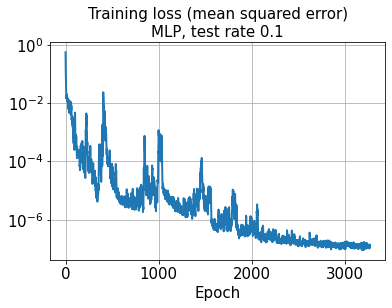

In [68]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, test rate 0.1', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

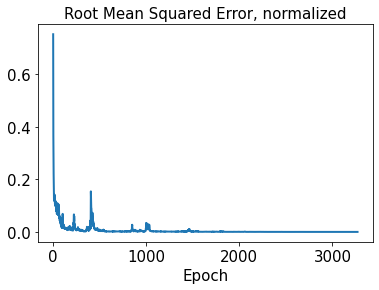

In [40]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

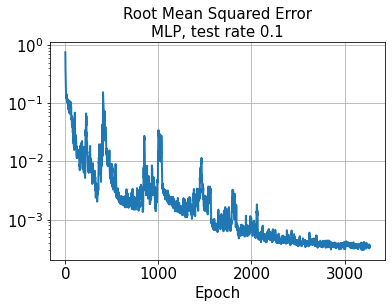

In [67]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, test rate 0.1', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [42]:
train_results = model.evaluate(x_train, y_train)

5/5 [==============================] - 0s 4ms/step - loss: 1.6611e-07 - rmse: 4.0757e-04


In [43]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 31ms/step - loss: 3.0186e-05 - rmse: 0.0055


In [44]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [45]:
model_directory = "D:\\TrainedModels\\20221128"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221128steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [69]:
os.chdir(storage_dir)

In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.00047715109010955685


In [50]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.0063499291548094645


In [51]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.009179716418992201


In [52]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.000336349635683521


In [53]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.022923747412218823


In [54]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.006311274003616343


In [55]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [57]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [58]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [59]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [60]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

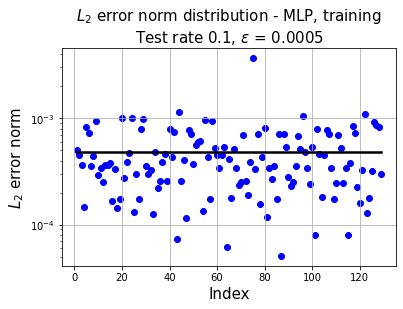

In [70]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

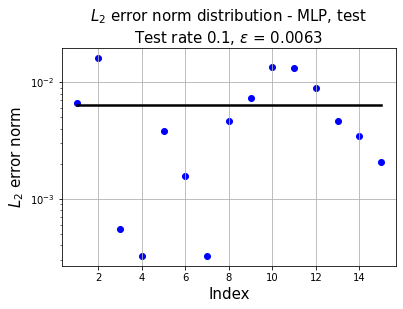

In [71]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

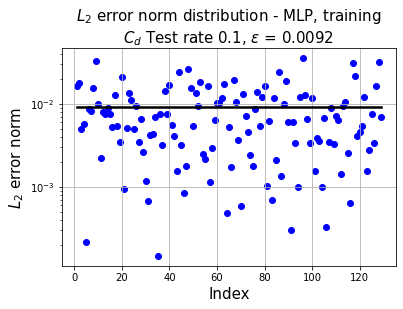

In [72]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

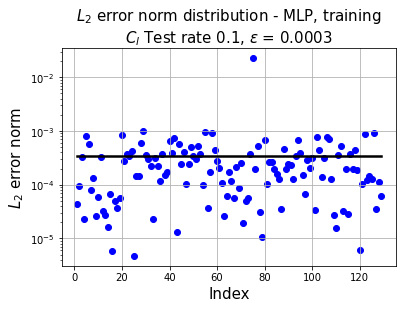

In [73]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

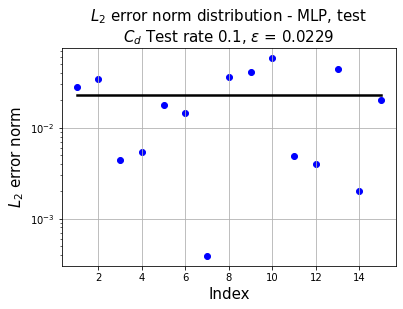

In [74]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

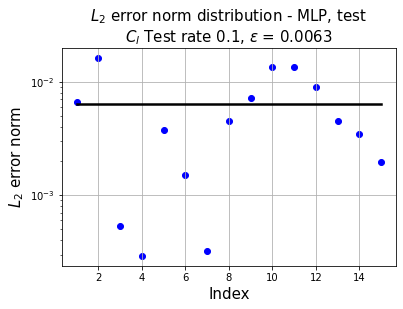

In [75]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [78]:
aa = aa*np.max(alpha)

In [81]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))

In [82]:
iTrain=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
    
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [83]:
iTrain = np.array(iTrain)
iTest = np.array(iTest)

In [79]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0121, L2 error of Cl: 0.0010


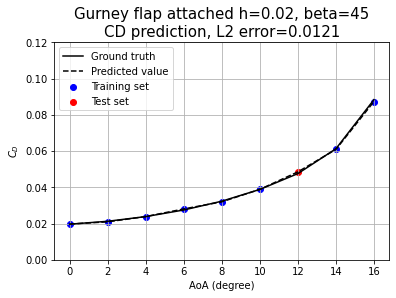

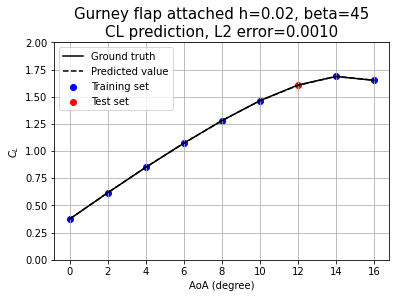

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0117, L2 error of Cl: 0.0010


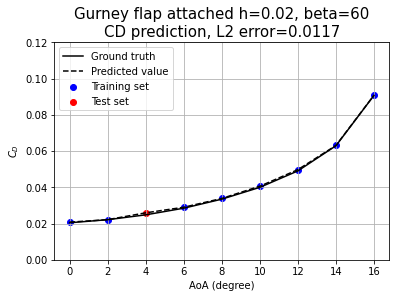

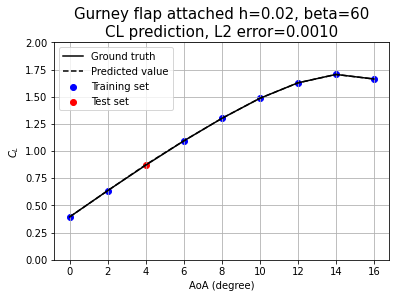

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0127, L2 error of Cl: 0.0003


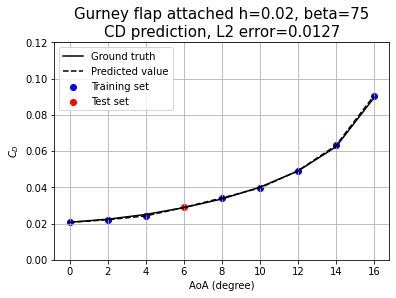

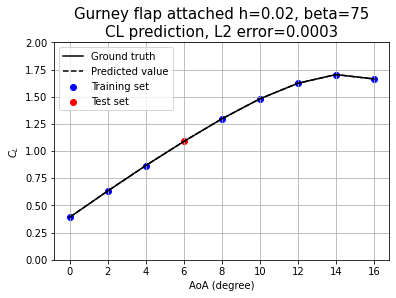

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0106, L2 error of Cl: 0.0035


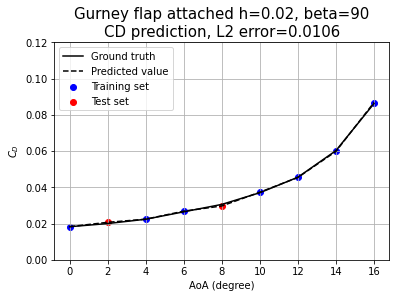

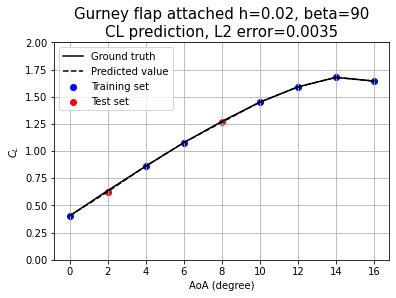

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0096, L2 error of Cl: 0.0004


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

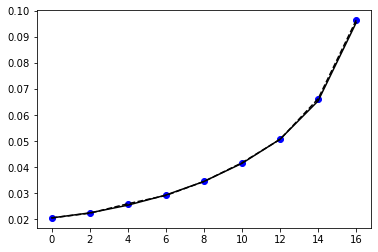

In [92]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(7, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)
    aTest = np.array(alpha_test)
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_NACA0018.jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    elif i==1:
        pass
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCL prediction, L2 error=%.4f'%(h[i], beta[i], l2_error_Cl), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()